## We want to create a diversified Portfolio, model a hypothetical catastrophic event through a single day stock price drop of 10%(all stocks), and then compare it to the calculated 1-day VaR and CVaR. At the end we backtest by comparing to historical data for COVID crash

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [2]:
import yfinance as yf
import time
tickers = ['AAPL','MSFT', 'GOOG', 'NVDA', 'AMZN']

start_date = '2020-01-01' # Covid crash
end_date = '2024-06-01'

adj_close_data={}

for ticker in tickers:
    print(f"Downloading {ticker}...")
    t = yf.Ticker(ticker)
    df = t.history(start=start_date, end=end_date)
    adj_close_data[ticker] = df['Close']  # or 'Adj Close' if available
    time.sleep(0.5)  # optional delay just in case to prevent the server from being overloaded with requests

# Combine into dataframe
data = pd.DataFrame(adj_close_data)
print(data.head())

                                AAPL        MSFT       GOOG      NVDA  \
Date                                                                    
2020-01-02 00:00:00-05:00  72.620842  153.042297  67.964500  5.971747   
2020-01-03 00:00:00-05:00  71.914833  151.136673  67.630981  5.876163   
2020-01-06 00:00:00-05:00  72.487854  151.527283  69.298576  5.900805   
2020-01-07 00:00:00-05:00  72.146935  150.145721  69.255341  5.972246   
2020-01-08 00:00:00-05:00  73.307526  152.537292  69.801086  5.983446   

                                AMZN  
Date                                  
2020-01-02 00:00:00-05:00  94.900497  
2020-01-03 00:00:00-05:00  93.748497  
2020-01-06 00:00:00-05:00  95.143997  
2020-01-07 00:00:00-05:00  95.343002  
2020-01-08 00:00:00-05:00  94.598503  


In [3]:
returns=data.pct_change().dropna() #daily returns
weights = np.array([1/len(tickers)]*len(tickers)) #portfolio weights, here all weights equal
portfolio_returns=returns.dot(weights)
mean=portfolio_returns.mean()
std_dev=portfolio_returns.std()

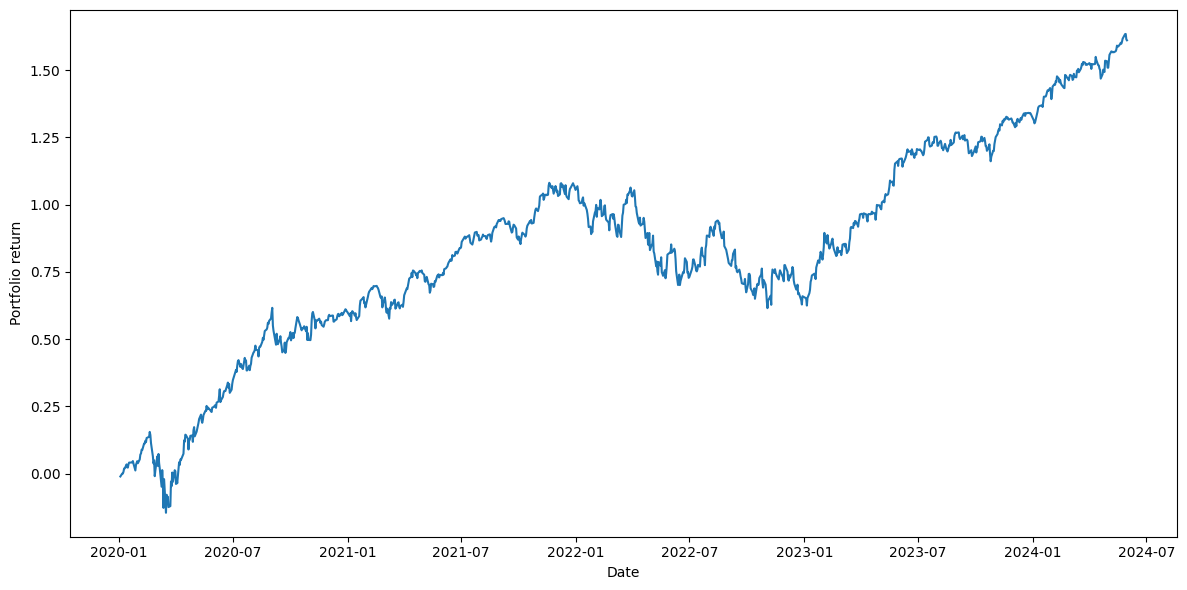

In [4]:
plt.figure(figsize=(12,6))
plt.plot(portfolio_returns.index, portfolio_returns.cumsum(), label = 'Cumulative Portfolio Return')
plt.xlabel('Date')
plt.ylabel('Portfolio return')
plt.tight_layout()
plt.show()

In [5]:
from scipy.stats import t

In [6]:
df, loc, scale = t.fit(portfolio_returns)

In [7]:
loc, scale

(np.float64(0.0018830669166101572), np.float64(0.01523361567783246))

In [8]:
mean, std_dev

(np.float64(0.0014518518308174974), np.float64(0.020276938968507477))